# Comparison of $L^2_\mu$ and $H^1_\mu$ Neural Operator Inverse Solutions

In [1]:
# MIT License
# Copyright (c) 2025
#
# This is part of the dino_tutorial package
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND.
# For additional questions contact Thomas O'Leary-Roseberry

import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_PATH', "../") )
from hippylib import *

# from misfits import *

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

from linear_elasticity_model import *

from plotting_utils import *

In [2]:
settings = linear_elasticity_settings()
model = linear_elasticity_model(settings)

Vh = model.problem.Vh

Number of dofs: STATE=1722, PARAMETER=861, ADJOINT=1722
Number of observation points: 50


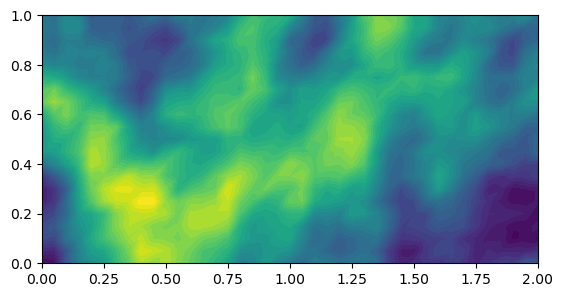

In [3]:
m_true = true_parameter(model.prior)
m_true_func = dl.Function(model.problem.Vh[hp.PARAMETER])
# m_true_func.vector().zero()
# m_true_func.vector().axpy(1.,m_true)

noise = dl.Vector()
model.prior.init_vector(noise,"noise")
hp.parRandom.normal(1., noise)
mtrue = dl.Vector()
model.prior.init_vector(mtrue, 0)
model.prior.sample(noise, mtrue)
m_true_func.vector().zero()
m_true_func.vector().axpy(1.,mtrue)

dl.plot(m_true_func)

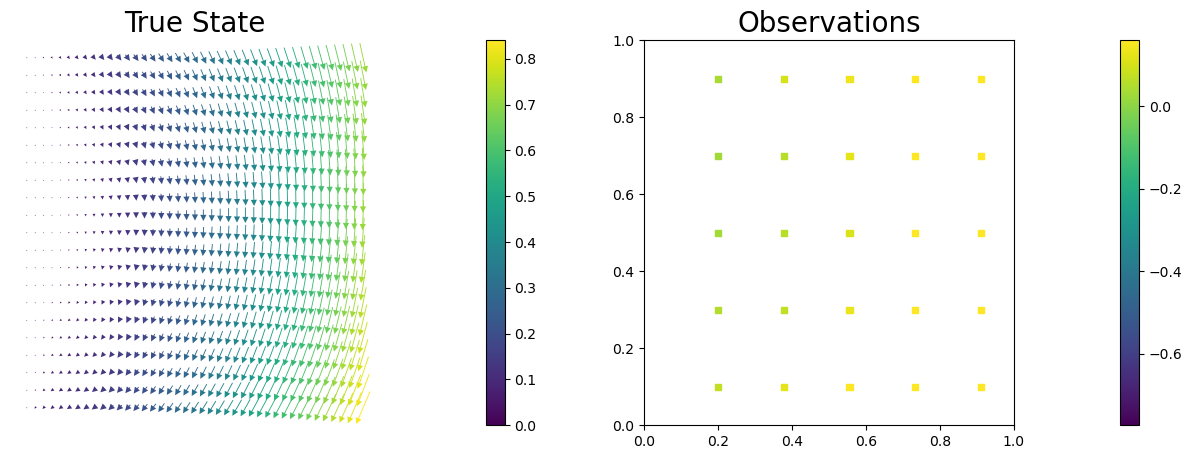

In [4]:
rel_noise = 0.01

utrue = model.problem.generate_state()
x = [utrue, mtrue, None]
model.problem.solveFwd(x[STATE], x)

model.misfit.B.mult(x[STATE], model.misfit.d)

MAX = model.misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, model.misfit.d)
model.misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), model.misfit.d.max() )
vmin = min( utrue.min(), model.misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(model.problem.Vh[hp.STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
norm = np.linalg.norm(model.misfit.d.get_local().reshape((-1, 2)), axis=1)
tmp = dl.Vector(dl.MPI.comm_world, len(norm))
tmp.set_local(norm)
nb.plot_pts(model.targets, tmp, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)

    
plt.show()

In [5]:
if False:
    m0 = dl.interpolate(dl.Expression("sin(x[0])", degree=5), Vh[hp.PARAMETER])
    _ = hp.modelVerify(model, m0.vector())

## MAP pt estimate with the true model


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.737083e+02    3.731990e+02    5.092327e-01   -3.029193e+04   6.971382e+04   1.000000e+00   5.000000e-01
  2   2    1.397646e+02    1.388299e+02    9.347162e-01   -4.676447e+02   3.537100e+03   1.000000e+00   2.252497e-01
  3   6    6.635175e+01    6.065834e+01    5.693410e+00   -1.720202e+02   3.290414e+02   1.000000e+00   6.870144e-02
  4   1    5.280694e+01    4.715277e+01    5.654167e+00   -2.709727e+01   1.598193e+03   1.000000e+00   1.514102e-01
  5  10    4.847346e+01    3.911664e+01    9.356826e+00   -8.999766e+00   5.868055e+01   1.000000e+00   2.901267e-02
  6   4    4.842459e+01    3.909647e+01    9.328117e+00   -9.979714e-02   4.837921e+01   1.000000e+00   2.634329e-02
  7  15    4.839568e+01    3.908425e+01    9.311430e+00   -5.785616e-02   4.485396e+00   1.000000e+00   8.021230e-03
  8   9    4.839568e+01    3.908460e+01    9.311078e+00   -1.

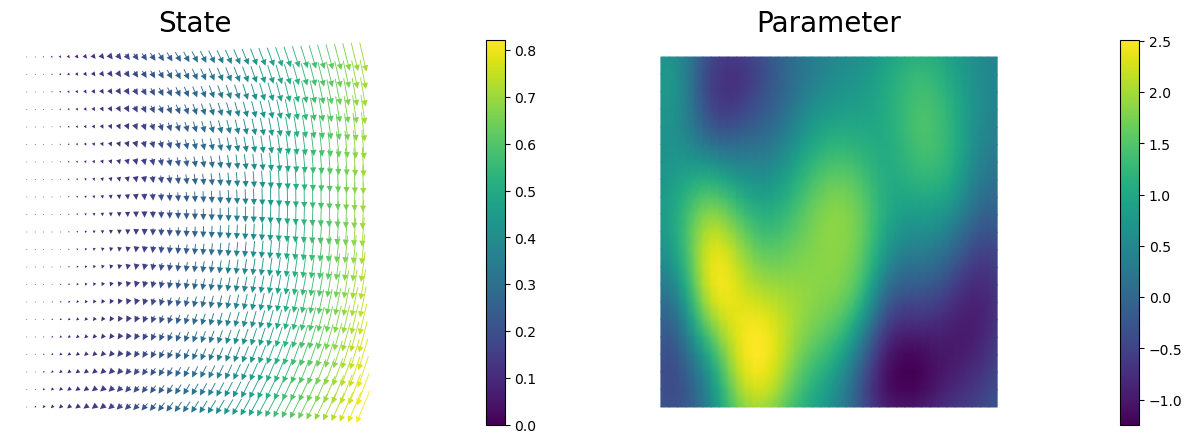

In [6]:
m = model.prior.mean.copy()
solver = hp.ReducedSpaceNewtonCG(model)
solver.parameters["rel_tolerance"] = 1e-8
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"]      = 25
solver.parameters["GN_iter"] = 5
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4


x = solver.solve([None, m, None])

if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[hp.STATE], x[hp.STATE]), subplot_loc=121,mytitle="State")
nb.plot(dl.Function(Vh[hp.PARAMETER], x[hp.PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

## Solve inverse problems with neural operators instead

In [7]:
import torch
import torch.optim as opt
from torch.utils.data import DataLoader

sys.path.append('../../')

from dinotorch_lite import *

from ip_utilities import map_estimate

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

## Load RBNO networks, evaluate and make plots

In [8]:
data_dir = 'data/full_state/'

rM = 100
rQ = 100

mq_data_dict = np.load(data_dir+'mq_data.npz')
# J_data_dict = np.load(data_dir+'JstarPhi_data_reduced.npz')

m_data = mq_data_dict['m_data']
q_data = mq_data_dict['q_data']

n_data, dQ = q_data.shape
n_data, dM = m_data.shape

# AS basis was used
os.listdir(data_dir)
AS_basis = np.load(data_dir + 'AS_input_decoder.npy')[:,:rM]
AS_encoder = np.load(data_dir + 'AS_input_encoder.npy')[:,:rM]

# POD basis was used
POD_basis = np.load(data_dir + 'POD/POD_decoder.npy')[:,:rQ]
POD_encoder = np.load(data_dir + 'POD/POD_encoder.npy')[:,:rQ]
POD_shift = np.load(data_dir + 'POD/POD_shift.npy')

m_test = torch.Tensor(m_data[-200:])
q_test = torch.Tensor(q_data[-200:])

POD_basis = torch.Tensor(POD_basis).to(torch.float32)
POD_shift = torch.Tensor(POD_shift).to(torch.float32)

AS_encoder = torch.Tensor(AS_encoder).to(torch.float32)

# Prior precision
R = np.load(data_dir +'R.npy')
R = torch.Tensor(R).to(torch.float32)


l2test = L2Dataset(m_test,q_test)
batch_size = 32

validation_loader = DataLoader(l2test, batch_size=batch_size, shuffle=True)

def load_rbno(model_name, dM,dQ,device,validation_loader, verbose = False):

    coeff_network = MLP(input_size = dM, output_size=dQ, hidden_layer_list = 4*[256],).to(device)
    coeff_network.load_state_dict(torch.load(data_dir+model_name))
    network = RBLift(coeff_network, AS_encoder, POD_basis, POD_shift)
    
    rel_error = evaluate_l2_error(network,validation_loader)
    if verbose:
        print(f'Loading {model_name}')
        print(f'Error = {rel_error}')
    return network, rel_error




## Load the networks

In [9]:
n_datas = [25,50,100,200,400,800]
l2_network_names = ['l2_model_'+str(n_data)+'.pth' for n_data in n_datas]
dino_network_names = ['dino_model_'+str(n_data)+'.pth' for n_data in n_datas]

l2_networks = []
l2_errors = []
for name in l2_network_names:
    network,error = load_rbno(name,rM,rQ,device, validation_loader)
    l2_networks.append(network)
    l2_errors.append(error)
    

dino_networks = []
dino_errors = []
for name in dino_network_names:
    network,error = load_rbno(name,rM,rQ,device, validation_loader)
    dino_networks.append(network)
    dino_errors.append(error)

    
    


FileNotFoundError: [Errno 2] No such file or directory: 'data/full_state/l2_model_25.pth'

## Plot $L^2_\mu$ generalization accuracies

In [ ]:
plt.loglog(n_datas, l2_errors, label=r"$L^2_\mu$ NO", linestyle='-', marker='o')
plt.loglog(n_datas,dino_errors, label=r"DINO", linestyle='--', marker='s')
plt.legend()
plt.xlabel("# training data")
plt.ylabel("relative error")
plt.title(r"$L^2_\mu$ vs DINO generalization")
plt.show()

## Vizualize IP solutions

In [ ]:
l2rbno_ip_errors = []
dirbno_ip_errors = []

for n_data, l2_rbmodel, dino_rbmodel in list(zip(n_datas,l2_networks,dino_networks)):
    l2_map = map_estimate(l2_rbmodel, model, R=R, output_type = 'full_state',\
                          iterations = 100,verbose=False)
    dino_map = map_estimate(dino_rbmodel, model, R=R, output_type = 'full_state',\
                            iterations = 100,verbose=False)

    
    l2_map_func = dl.Function(Vh[hp.PARAMETER])
    dino_map_func = dl.Function(Vh[hp.PARAMETER])
    true_map_func = dl.Function(Vh[hp.PARAMETER],x[hp.PARAMETER])
    
    l2_error = dl.Function(Vh[hp.PARAMETER])
    dino_error = dl.Function(Vh[hp.PARAMETER])
    l2err = np.abs(l2_map - true_map_func.vector().get_local())
    l2_error.vector().set_local(l2err)
    dino_error.vector().set_local(np.abs(dino_map - true_map_func.vector().get_local()))

    l2rbno_ip_errors.append(dl.norm(l2_error)/dl.norm(true_map_func))
    dirbno_ip_errors.append(dl.norm(dino_error)/dl.norm(true_map_func))
    
    ip_sols = [l2_error,dino_error]
    titles = [r"$L^2_\mu$ error N="+str(n_data),r"$H^1_\mu$ error N="+str(n_data)]
    ip_solution_plot(ip_sols,titles)

## Plot IP errors

In [ ]:
plt.loglog(n_datas, l2rbno_ip_errors, label=r"$L^2_\mu$ NO", linestyle='-', marker='o')
plt.loglog(n_datas,dirbno_ip_errors, label=r"DINO", linestyle='--', marker='s')
plt.legend()
plt.xlabel("# training data")
plt.ylabel("relative error")
plt.title(r"$L^2_\mu$ vs DINO inversion errors")
plt.show()